In [1]:
import os

In [2]:
# import json
import pandas as pd

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.data import TFRecordDataset

In [4]:
import wav

In [5]:
import matplotlib.pyplot as plt

In [6]:
tf.__version__

'1.14.0'

In [7]:
# fpath = "/Users/jvincent/Documents/SCU/deepLearning/Respiratory_Sound_Database/Respiratory_Sound_Database/info.json"
# with open(fpath, 'r') as fp:
#     fnames, clbls = json.load(fp)

In [8]:
# print(type(fnames[0]))
# print(type(clbls[0]))

In [9]:
# for i in range(len(clbls)):
#     clbls[i] = int(clbls[i])

In [10]:
path = "/Users/jvincent/Documents/SCU/deepLearning/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv"
df = pd.read_csv(path, header = None)

In [11]:
# dictionary of disease classes
classes = {"Healthy" : 0, "Asthma" : 1, "COPD" : 2, "LRTI" : 3, "URTI" : 4, "Bronchiectasis" : 5, "Bronchiolitis" : 6, "Pneumonia" : 7}

In [12]:
# hash table of patient diagnoses
diagnoses = np.zeros(np.max(df.iloc[:][0]) - np.min(df.iloc[:][0]) + 1)
for i in range(len(df.iloc[:][1])):
    diagnoses[i] = classes[df.iloc[i][1]]
print(diagnoses)

[4. 0. 1. 2. 4. 2. 2. 3. 2. 2. 5. 2. 2. 2. 3. 5. 2. 2. 4. 2. 0. 7. 0. 2.
 0. 0. 0. 2. 4. 2. 4. 2. 2. 2. 7. 0. 4. 2. 2. 7. 2. 2. 0. 0. 2. 2. 2. 4.
 6. 4. 2. 0. 0. 2. 2. 2. 2. 2. 0. 2. 6. 2. 2. 4. 4. 2. 6. 5. 5. 2. 0. 2.
 6. 2. 2. 2. 2. 2. 0. 2. 2. 0. 0. 0. 2. 2. 0. 4. 2. 4. 7. 2. 2. 0. 2. 5.
 4. 2. 2. 2. 5. 0. 2. 2. 2. 6. 2. 0. 0. 4. 2. 2. 2. 0. 5. 6. 0. 2. 7. 2.
 2. 2. 2. 0. 0. 7.]


In [13]:
root = "/Users/jvincent/Documents/SCU/deepLearning/Respiratory_Sound_Database/Respiratory_Sound_Database/audio/"
os.chdir(root)

In [14]:
dirs = os.listdir(os.getcwd())

In [15]:
####
# Gather filenames

fnames = [] # list of filenames
clabels = []

for sub in dirs:
    subdir = os.path.join(root, sub)
    files = os.listdir(subdir)
    for file in files:
        audio = wav.read_wav(os.path.join(subdir, file))
        if(441000 <= len(audio)): # If there are at least ten seconds of audio
            fnames.append(os.path.join(subdir, file))
            clabels.append(int(diagnoses[int(sub)-101]))

In [16]:
print(len(fnames))
print(len(clabels))

824
824


In [17]:
root = "/Users/jvincent/Documents/SCU/deepLearning/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_tfrd/"
os.chdir(root) # Not that I really need to change back, but...

In [18]:
#### Create tf data record files

In [19]:
# convert to one of the three tensorflow data types : tf.train.ByteList, tf.train.FloatList, tf.train.Int64List
# Source : https://www.tensorflow.org/tutorials/load_data/tfrecord

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [20]:
# Create tf.Example
def to_tf_example(bytestring, lbl):
    
    feature = {"audio_raw" : _bytes_feature(bytestring),
                "label" : _int64_feature(lbl)}
    
    tf_example = tf.train.Example(features = tf.train.Features(feature = feature))
    return tf_example

In [21]:
# function to create a TFRecordDataset
# Each dataset, such as the train dataset is stored in a file as a binary representation
# After further review of the documentation, I found that I can use multiple files to create the dataset
# I would need to pass a list of files into the TFRecordDataset() function, but that is easy
def createTFRD(target_file, fnames, lbls):
    # fnames & lbls must be the same length, i.e. one label for each file
    
    # (1) open TFRD writer, which writes to the specified file
    writer = tf.python_io.TFRecordWriter(target_file)
    
    # (2) iteratively read files and write to the target file
    for i in range(len(fnames)):
         # read a wavfile and return numpy array
        audio = wav.read_wav(fnames[i])
        # Should I cut the audio to a uniform size? Yes.
        # Cut to first 10 seconds b/c each recording is at least 10 seconds long
        # 44100 Hz = f_sample
        # 44100 Hz * 10 s = 441000 points
        f_sample = 44100
        # five second sample
        start = 2
        end = 3
        audio = audio[start*f_sample:end*f_sample] # I love slicing!
        audio_raw = audio.tobytes() # Convert to bytestring
        # Load the corresponding label
        lbl = lbls[i]
        tf_example = to_tf_example(audio_raw, lbl) # Convert to tf.Example
        writer.write(tf_example.SerializeToString()) # SerializeToString() converts to a bytestring    
    writer.close()

In [22]:
# (4) split filepaths & labels into train, val, and test
def split(filepaths, lbls, val_prct, test_prct):
    # Note : filepaths must have the same length as lbls
    val_names = filepaths[:int(val_prct*len(filepaths))] # first, get the validation data
    test_names = filepaths[int(val_prct*len(filepaths)):int((test_prct*len(filepaths)))+int((val_prct*len(filepaths)))] # then, the test data
    train_names = filepaths[int(test_prct*len(filepaths))+int(val_prct*len(filepaths)):] # the rest is training data
    val_lbls = lbls[:int(val_prct*len(filepaths))]
    test_lbls = lbls[int(val_prct*len(filepaths)):int(test_prct*len(filepaths))+int(val_prct*len(filepaths))]
    train_lbls = lbls[int(test_prct*len(filepaths))+int(val_prct*len(filepaths)):]
    return train_names, val_names, test_names, train_lbls, val_lbls, test_lbls # Remember that these are just filepaths

In [23]:
train_names, val_names, test_names, train_lbls, val_lbls, test_lbls = split(fnames, clabels, 0.10, 0.20)

In [24]:
# (5) use function (3) to create the .tfrecords
train_path = "/Users/jvincent/Documents/SCU/deepLearning/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_tfrd/train.tfrecords"
val_path = "/Users/jvincent/Documents/SCU/deepLearning/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_tfrd/val.tfrecords"
test_path = "/Users/jvincent/Documents/SCU/deepLearning/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_tfrd/test.tfrecords"

createTFRD(train_path, train_names, train_lbls)
createTFRD(val_path, val_names, val_lbls)
createTFRD(test_path, test_names, test_lbls)

In [25]:
#### Load tf data record files

In [26]:
# (1) parser function/decoder function to read each individual audio sample and its respective label
def parser(serialized_example):
    f_sample = 44100
    start = 2
    end = 3
    
    features = {"audio_raw": tf.io.FixedLenFeature([], tf.string),
                "label": tf.io.FixedLenFeature([], tf.int64)}
    
    tf_example = tf.io.parse_single_example(serialized_example, features)
    
    audio_raw = tf_example["audio_raw"]
    audio = tf.decode_raw(audio_raw, tf.float64, True) # first argument : dtype to write as, second argument : output type, third argument : little-endian
    audio = tf.reshape(audio, ((end*f_sample) - (start*f_sample), 1)) # Reshape to original audio dimension
    audio = tf.cast(audio, tf.float32) # Cast to float32 because that is the standard for machine learning
    lbl = tf_example["label"]
    lbl = tf.cast(lbl, tf.int32)
    return audio, lbl # Should I return a dictionary?

In [27]:
# (2) read tf data record
# The filenames argument to the TFRecordDataset initializer can either be a string, a list of strings, or a tf.Tensor of strings. Therefore if you have two sets of files for training and validation purposes, you can create a factory method that produces the dataset, taking filenames as an input argument:
def loadTFRD(fnames, shuffle, batch_size):
    ds = tf.data.TFRecordDataset(filenames = fnames)
    ds = ds.map(parser) # applies the parser to a sample once it extracts it from the .tfrecords file
    
    if(shuffle):
        ds = ds.shuffle(len(fnames)) # buffer_size = number of elements in the ds
        # I could also do the shuffling step with the filename lists, but that won't be necessary if this works
    ds = ds.batch(batch_size) # batch the dataset
    ds = ds.make_one_shot_iterator()
    
    return ds

In [28]:
batch_size = 1
train_ds = loadTFRD(train_path, True, batch_size)
val_ds = loadTFRD(val_path, True, batch_size)
test_ds = loadTFRD(test_path, True, batch_size)

W0226 20:44:35.080738 4643636672 deprecation.py:323] From <ipython-input-27-8cd66aec99f5>:11: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


In [29]:
audio_batch, lbl_batch = train_ds.get_next()

(1, 44100, 1)


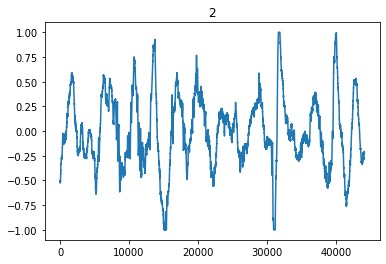

In [31]:
# I have an odd input shape. I need to make sure that each sample is up to length prior to making the dataset.
with tf.Session() as sess:
    audio_form = sess.run(audio_batch)
    lbl_form = sess.run(lbl_batch)
    batch_num = 0
    plt.plot(audio_form[batch_num])
    plt.title(lbl_form[batch_num])
    print(audio_form.shape)